
# Autoencoder 와 지도학습 모델을 이용한 신용카드 Fraud Detection

- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. 'time' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다.



- 'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
tf.__version__

'2.15.0'

## Downloading of dataset

In [3]:
df = pd.read_csv( 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- the dataset is highly unbalanced

In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
# 'Class' 열에서 사기(Fraud) 데이터의 개수를 계산합니다. 사기는 'Class' 값이 1인 경우입니다.
fraud = (df['Class'] == 1).sum()

# 'Class' 열에서 정상(Normal) 데이터의 개수를 계산합니다. 정상 데이터는 'Class' 값이 0인 경우입니다.
normal = (df['Class'] == 0).sum()

# 전체 데이터의 개수를 계산합니다. 사기 데이터와 정상 데이터의 합입니다.
total = fraud + normal

print(f"Total = {total:,}")

# 전체 데이터에 대한 백분율로 계산하여 출력합니다.
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


- Time 필드를 일중 시간으로 변환합니다.   
- Amount 필드는 로그 스케일로 변환합니다.

In [6]:
# 'Time' 열의 값을 일중 시간 형식으로 변환합니다.
# 각 값 x를 3600(초)로 나누어 시간 단위로 변환하고, 24로 나눈 나머지 값을 계산합니다.
# 이는 시간을 24시간 형식으로 맞추기 위해 사용됩니다.
df.loc[:, "Time"] = df.loc[:, "Time"].apply(lambda x: x / 3600 % 24)

# 'Amount' 열의 값을 로그 변환합니다.
# 로그 변환을 위해 각 값에 1을 더한 후 자연 로그를 계산합니다.
# 이는 데이터의 분포를 정규 분포에 가깝게 만들어 모델 학습에 도움이 되도록 하기 위함입니다.
df.loc[:, 'Amount'] = np.log(df.loc[:, 'Amount'] + 1)

- class 1 이 너무 적으므로 통상적인 7:3 대신 5:5 비율로 train, test set 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'],
                                                    test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test  = sc.transform(X_test.values)

In [9]:
# Train set의 정상/사기 거래 비율
y_train.value_counts() / y_train.count()

Class
0    0.998251
1    0.001749
Name: count, dtype: float64

In [10]:
# Test set 의 정상/사기 거래 비율
y_test.value_counts() / y_test.count()

Class
0    0.998294
1    0.001706
Name: count, dtype: float64

## Autoencoder Train

- 모든 데이터를 이용하여 autoencoder 학습

- Autoencoder 의 encoder 부분을 feature extractor 로 이용

## autoencoder의 인코더 부분 및 k-NN / SVC 사용

훈련 데이터세트의 모든 사례 (사기/정상)를 사용하여 훈련하고 그 결과를 사용하여 인스턴스들을 12 차원 공간에 매핑합니다. 매핑된 케이스는 분류를 위해 k-NN, SVM, DNN 모델에 공급됩니다.

### Auto Encoder model 작성
- encoder 부분만 사용할 수 있도록 encoder 와 decoder network 을 분리하여 작성
- decoder는 훈련된 encoder를 얻기 위한 역할

In [11]:
# 입력 레이어를 정의합니다. 입력 데이터의 형태는 30차원입니다.
input_layer = Input(shape=(30, ))

# 인코더(Encoder) 레이어를 정의합니다.
encoded_all = Dense(12, activation='relu')(input_layer)

# 디코더(Decoder) 레이어를 정의합니다.
decoded_all = Dense(30)(encoded_all)

# 인코더 모델을 정의합니다.
encoder_all = Model(input_layer, encoded_all)

# 오토인코더(Autoencoder) 모델을 정의합니다.
autoencoder_all = Model(input_layer, decoded_all)

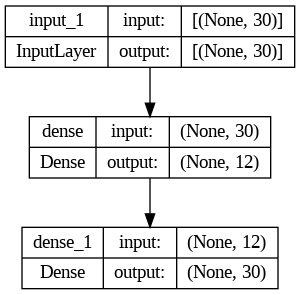

In [12]:
plot_model(autoencoder_all, show_shapes=True)

In [13]:
autoencoder_all.compile(optimizer='adam', loss='mse')

history = autoencoder_all.fit(X_train, X_train, epochs = 30,
                              batch_size=128, validation_data=(X_test, X_test))

Epoch 1/30
1113/1113 [==============================] - 6s 4ms/step - loss: 0.7550 - val_loss: 0.6128
Epoch 2/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5884 - val_loss: 0.5681
Epoch 3/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5654 - val_loss: 0.5604
Epoch 4/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5609 - val_loss: 0.5616
Epoch 5/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5597 - val_loss: 0.5588
Epoch 6/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5590 - val_loss: 0.5605
Epoch 7/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5585 - val_loss: 0.5591
Epoch 8/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.5582 - val_loss: 0.5594
Epoch 9/30
1113/1113 [==============================] - 4s 3ms/step - loss: 0.5578 - val_loss: 0.5601
Epoch 10/30
1113/1113 [==============================] - 4s 4ms/step - loss: 0.557

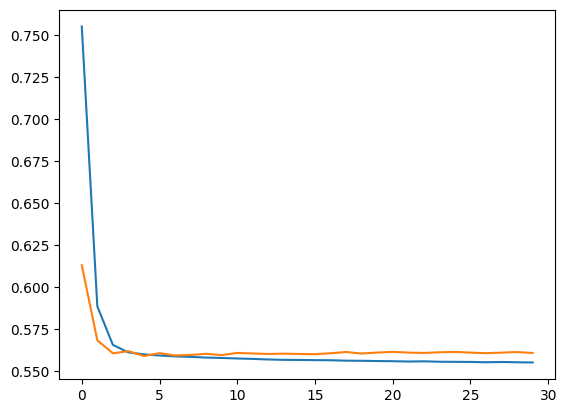

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## KNN, SVC
- train input 으로 사용하기 위한 encoder output 출력

In [15]:
enc_all = encoder_all.predict(X_train)
enc_all.shape

4451/4451 [==============================] - 5s 1ms/step


(142403, 12)

- encoder output 을 feature 로 이용하여 knn, svc model train

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 서포트 벡터 머신(SVM) 모델을 생성합니다.
model_svc = SVC()

# k-NN 분류기를 생성합니다.
model_knn = KNeighborsClassifier(n_neighbors=3)

In [17]:
# training set을 encoder에 통과시켜 얻은 feature를 이용하여 model 훈련
model_svc.fit(enc_all, y_train)

SVC()

In [18]:
model_knn.fit(enc_all, y_train)

KNeighborsClassifier(n_neighbors=3)

- train 된 모델을 이용하여 test set 분류

In [19]:
%%time
# encoder_all 모델은 입력 데이터를 압축된 표현(저차원 공간)으로 변환합니다.
encoded_test_data = encoder_all.predict(X_test)

# SVM 모델을 사용하여 인코더 모델의 출력 대해 클래스 레이블을 예측합니다.
predicted_svc = model_svc.predict(encoded_test_data)

# 예측된 클래스 레이블을 출력합니다.
print(predicted_svc)

4451/4451 [==============================] - 5s 1ms/step
[0 0 0 ... 0 0 0]
CPU times: user 15.6 s, sys: 741 ms, total: 16.3 s
Wall time: 15.1 s


In [20]:
%%time
# encoder_all 모델은 입력 데이터를 압축된 표현(저차원 공간)으로 변환합니다.
encoded_test_data = encoder_all.predict(X_test)

# k-NN 모델을 사용하여 인코더 모델의 출력 대해 클래스 레이블을 예측합니다.
predicted_knn = model_knn.predict(encoded_test_data)

# 예측된 클래스 레이블을 출력합니다.
print(predicted_knn)

4451/4451 [==============================] - 5s 1ms/step
[0 0 0 ... 0 0 0]
CPU times: user 1min 5s, sys: 1.16 s, total: 1min 6s
Wall time: 1min 5s


### DNN 이진 분류 모델 작성

In [21]:
model_dnn = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', input_shape=(enc_all.shape[-1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

model_dnn.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy', metrics=['accuracy'])

In [22]:
# encoder_all 모델은 입력 데이터를 압축된 표현(저차원 공간)으로 변환합니다.
enc_test = encoder_all.predict(X_test)

enc_test.shape

4451/4451 [==============================] - 5s 1ms/step


(142404, 12)

In [23]:
history = model_dnn.fit(enc_all, y_train, epochs=50, batch_size=1024,
                    validation_data=(enc_test, y_test))

Epoch 1/50
140/140 [==============================] - 3s 6ms/step - loss: 0.1160 - accuracy: 0.9826 - val_loss: 0.0443 - val_accuracy: 0.9983
Epoch 2/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0468 - accuracy: 0.9983 - val_loss: 0.0294 - val_accuracy: 0.9983
Epoch 3/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0296 - accuracy: 0.9982 - val_loss: 0.0125 - val_accuracy: 0.9983
Epoch 4/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0150 - accuracy: 0.9984 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 5/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0114 - accuracy: 0.9986 - val_loss: 0.0066 - val_accuracy: 0.9991
Epoch 6/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0098 - accuracy: 0.9986 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 7/50
140/140 [==============================] - 1s 5ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9992
Epoch 

In [24]:
predicted_dnn = model_dnn.predict(encoder_all.predict(X_test)) > 0.5
predicted_dnn.shape

4451/4451 [==============================] - 6s 1ms/step


(142404, 1)

분류기로 사용한 전통적 머신러닝 2 개 모델과 딥러닝 모델의 성능 비교

Precision 0.92
Recall 0.65


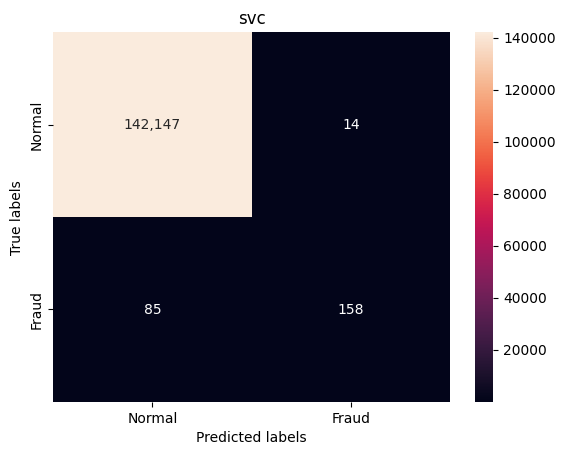

Precision 0.92
Recall 0.75


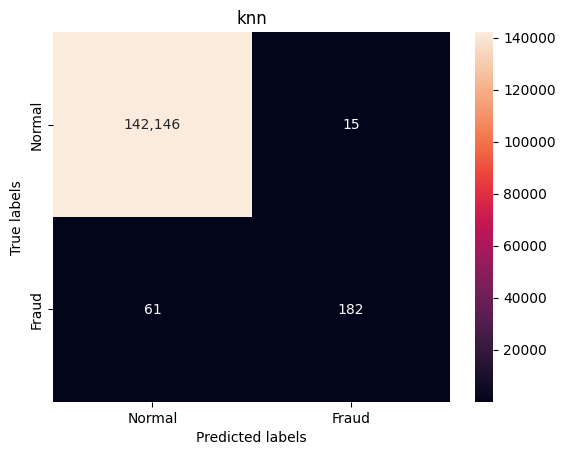

Precision 0.84
Recall 0.75


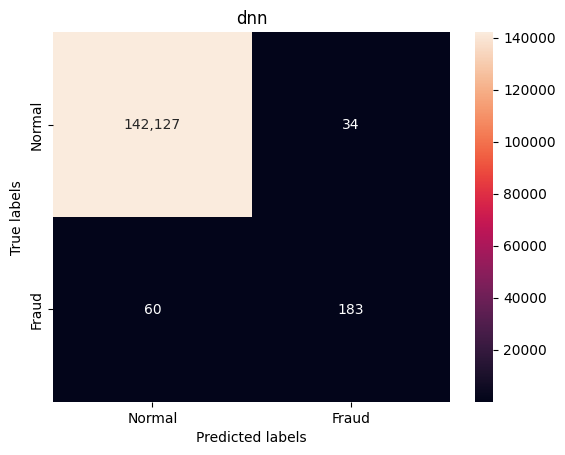

In [25]:
for model, predicted in [("svc", predicted_svc),
                         ("knn", predicted_knn),
                         ("dnn", predicted_dnn)]:

    # 정밀도(Precision)를 계산하여 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, predicted)))
    # 재현율(Recall)을 계산하여 출력합니다.
    print("Recall {:.2f}".format(recall_score(y_test, predicted)))

    # 혼동 행렬(confusion matrix)을 계산합니다.
    cm = confusion_matrix(y_test, predicted)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')

    # x축 레이블을 설정합니다.
    ax.set_xlabel('Predicted labels')

    # y축 레이블을 설정합니다.
    ax.set_ylabel('True labels')

    # 그래프의 제목을 설정합니다. 제목은 모델의 이름입니다.
    ax.set_title(model)

    # x축 틱 레이블을 설정합니다.
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])

    # y축 틱 레이블을 설정합니다.
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])

    # 틱 위치를 설정합니다.
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])

    # 그래프를 화면에 표시합니다.
    plt.show()